# Pretrained CNN - Feature Extraction
In diesem Code Notebook verwenden wir für die Vorhersage von Katze und Hund ein vortrainiertes Modell. Dabei gehen wir nach dem Vorgehen der Feature Extraction. Die Codes stammen aus dem Buch von Chollet (2018).

## Loading Packages

In [6]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

import matplotlib
import matplotlib.pyplot as plt # plotting library
%matplotlib inline
matplotlib.get_backend()

'module://matplotlib_inline.backend_inline'

## Data Path

In [7]:
# original_dataset_dir = '/Users/ystaudt/switchdrive/Bachelor_CDS/Deep_Learning/2023_Kursunterlagen/4_Convolutional_Neural_Networks/dogs-vs-cats/train'

original_dataset_dir = '../data/train'

#base_dir = '/Users/ystaudt/switchdrive/Bachelor_CDS/Deep_Learning/2023_Kursunterlagen/4_Convolutional_Neural_Networks/cats_and_dogs_small'

base_dir = '../data/cats_and_dogs_2k'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

## Data Preparation

In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
batch_size = 20

## Convolutional Base

In [9]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(150,150,3))

In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## Extract Feature Map

In [11]:
def extract_features(directory,sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=sample_count)
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size = batch_size,
        class_mode='binary'
    )
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

In [12]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 313ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 273ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 266ms/step


## Reshape the Tensors for Input in Dense Layers

In [13]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_featues = np.reshape(test_features, (1000, 4*4*512))

## Model building

In [14]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(tf.keras.layers.Dropout(0,.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

## Model compile

In [15]:
model.compile(loss='binary_crossentropy',
              metrics=['acc'],
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5))

## Model Fit

In [16]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 14ms/step - loss: 0.5184 - acc: 0.7695 - val_loss: 0.3972 - val_acc: 0.8500
Epoch 2/30
100/100 [==============================] - 1s 12ms/step - loss: 0.3468 - acc: 0.8650 - val_loss: 0.3230 - val_acc: 0.8830
Epoch 3/30
100/100 [==============================] - 1s 12ms/step - loss: 0.2815 - acc: 0.8990 - val_loss: 0.2876 - val_acc: 0.8940
Epoch 4/30
100/100 [==============================] - 1s 12ms/step - loss: 0.2446 - acc: 0.9115 - val_loss: 0.2812 - val_acc: 0.8850
Epoch 5/30
100/100 [==============================] - 1s 12ms/step - loss: 0.2190 - acc: 0.9215 - val_loss: 0.2570 - val_acc: 0.8990
Epoch 6/30
100/100 [==============================] - 1s 12ms/step - loss: 0.1997 - acc: 0.9320 - val_loss: 0.2543 - val_acc: 0.8960
Epoch 7/30
100/100 [==============================] - 1s 12ms/step - loss: 0.1823 - acc: 0.9420 - val_loss: 0.2435 - val_acc: 0.9030
Epoch 8/30
100/100 [==============================] - 1s 12ms/step - 

## Model Evaluation

In [17]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # Plot training and validation accuracy per epoch
    ax1.plot(epochs, acc, 'bo', label='Training acc')
    ax1.plot(epochs, val_acc, 'r-', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    # Plot training and validation loss per epoch
    ax2.plot(epochs, loss, 'bo', label='Training loss')
    ax2.plot(epochs, val_loss, 'r-', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    return fig

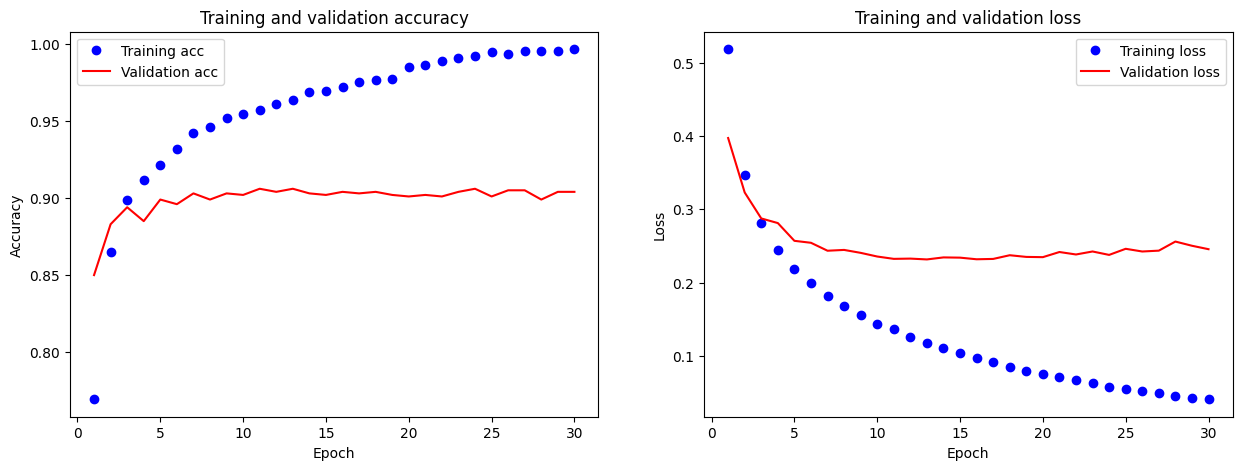

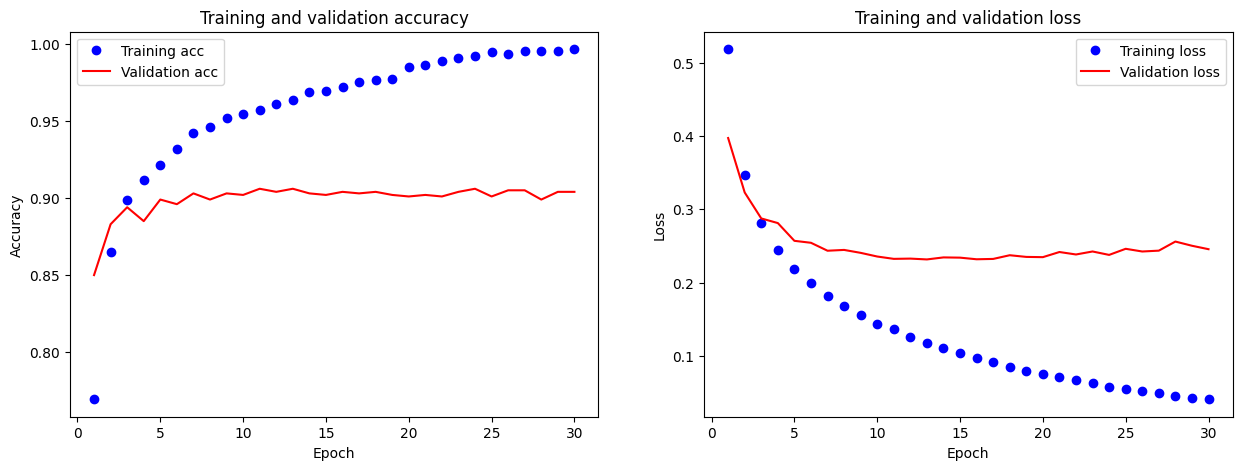

In [18]:
plot_history(history)

### Save Model

In [19]:
model.save('cats_and_dogs_extract_featuremap.h5')

## REFERENCES
Francois Chollet (2018), Deep Learning with Keras, Manning.